# Exploratory Data Analysis (EDA) of real estate prices


This is an EDA performed on the real estate market trends in Connecticut. 

The raw data file was obtained from https://catalog.data.gov/dataset/real-estate-sales-2001-2018. 

Table of content:

0. Librarie and Dataset imported
2. Basic EDA
3. 

### 0. Import the Libraries and the dataset:

Frequently used libraries are imported:

In [217]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

The dataset imported from the csv file:

In [224]:
cleaned_real_estate=pd.read_csv('../Datasets/cleaned_real_estate.csv')
cleaned_real_estate = cleaned_real_estate.reset_index(drop=True)

/var/folders/kv/4xjj0g696_lcyc7ms5pdd2t00000gn/T/ipykernel_16630/1283737223.py:1: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  cleaned_real_estate=pd.read_csv('../Datasets/cleaned_real_estate.csv')


To get the basic idea about the dataset, 10 rows are called:

In [219]:
cleaned_real_estate.sample(10)

,Unnamed: 0,Serial Number,List Year,Date Recorded,Town,Address,Assessed Value,Sale Amount,Sales Ratio,Property Type,Residential Type,Non Use Code,Assessor Remarks,OPM remarks,Full Address,latitude,longitude
95286,806012,160974,2016,04/06/2017,Bridgeport,72 REMINGTON ST,126390.0,169000.0,0.747870,Three Family,Three Family,NaN,NaN,NaN,"72, Remington St, Bridgeport, Connecticut, Uni...",-73.16743,41.19449
74256,673157,131148,2013,06/24/2014,Stamford,33 HILLANDALE AVENUE,162280.0,310000.0,0.523484,Single Family,Single Family,NaN,NaN,NaN,"33, Hillandale Avenue, Stamford, Connecticut, ...",-73.53219,41.06002
46859,509359,800094,2008,06/29/2009,Prospect,106 SYCAMORE DR,0.0,160000.0,0.000000,Condo,Condo,7.0,NEW CONST CO 05/12/2009,NaN,"106, Sycamore Dr, Prospect, Connecticut, Unite...",-72.97372,41.52369
46793,509000,80079,2008,10/18/2008,Waterbury,72 HEWLETT ST,217590.0,140000.0,1.554214,Single Family,Single Family,14.0,NaN,NaN,"72, Hewlett St, Waterbury, Connecticut, United...",-73.04514,41.56898
14239,33007,20193,2020,02/08/2021,North Haven,222 BLUE HILLS RD,202280.0,470000.0,0.430300,Residential,Single Family,NaN,NaN,NaN,"222, Blue Hills Rd, North Haven, Connecticut, ...",-72.87881,41.41770
39582,467343,70654,2007,07/28/2008,Hamden,116 GORHAM AVE,142800.0,221000.0,0.646154,Single Family,Single Family,NaN,NaN,NaN,"116, Gorham Ave, Hamden, Connecticut, United S...",-72.93824,41.34885
89811,769998,150124,2015,02/17/2016,Madison,54 SCENIC ROAD,205300.0,145065.0,1.415228,Single Family,Single Family,14.0,bank sale,NaN,"54, Scenic Road, Madison, Connecticut, United ...",-72.64232,41.34106
105689,873356,170410,2017,09/25/2018,East Lyme,77 LAURELWOOD DR,180670.0,237500.0,0.760700,Single Family,Single Family,NaN,NaN,NaN,"77, Laurelwood Dr, East Lyme, Connecticut, Uni...",-72.23104,41.30763
66120,621315,110726,2011,11/01/2011,Stratford,271 BOOTH ST,168560.0,235000.0,0.717277,Single Family,Single Family,NaN,NaN,NaN,"271, Booth St, Stratford, Connecticut, United ...",-73.13955,41.19716
45921,503654,80172,2008,08/24/2009,Montville,11 ANDERSEN LN,249230.0,333000.0,0.748438,Single Family,Single Family,NaN,NaN,NaN,"11, Andersen Ln, Montville, Connecticut, Unite...",-72.18150,41.46543


In [220]:
cleaned_real_estate = cleaned_real_estate.drop(cleaned_real_estate.columns[0], axis=1)
cleaned_real_estate

,Serial Number,List Year,Date Recorded,Town,Address,Assessed Value,Sale Amount,Sales Ratio,Property Type,Residential Type,Non Use Code,Assessor Remarks,OPM remarks,Full Address,latitude,longitude
0,200086,2020,08/10/2021,Bethlehem,39 WOODLAND RD,168900.0,352000.0,0.479800,Residential,Single Family,NaN,NaN,NaN,"39, Woodland Rd, Bethlehem, Connecticut, Unite...",-73.18197,41.64672
1,200639,2020,07/28/2021,Groton,4 TYLER AVE,259770.0,650000.0,0.399646,Residential,Single Family,NaN,NaN,NaN,"4, Tyler Ave, Groton, Connecticut, United States",-72.07229,41.32148
2,200020,2020,10/06/2020,Groton,98 EAST SHORE AVE,654570.0,990000.0,0.661182,Residential,Single Family,7.0,TEAR DOWN,NaN,"98, East Shore Ave, Groton, Connecticut, Unite...",-72.00446,41.31252
3,200038,2020,10/09/2020,Meriden,41 SUNNY LANE,209440.0,307000.0,0.682200,Residential,Single Family,NaN,NaN,NaN,"41, Sunny Lane, Meriden, Connecticut, United S...",-72.79013,41.51639
4,200374,2020,05/18/2021,Vernon,27 TRACY DRIVE,129190.0,226800.0,0.569600,Residential,Single Family,NaN,NaN,NaN,"27, Tracy Drive, Vernon, Connecticut, United S...",-72.47857,41.84938
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123749,190389,2019,03/24/2020,Norwich,17 VINE ST,86600.0,182000.0,0.475800,Three Family,Three Family,NaN,NaN,NaN,"17, Vine St, Norwich, Connecticut, United States",-72.07006,41.53315
123750,190478,2019,02/14/2020,Norwalk,38 HYATT AVE,283180.0,440000.0,0.643600,Single Family,Single Family,14.0,FORECLOSURE BY SALE: 1-7-9-0,NaN,"38, Hyatt Ave, Norwalk, Connecticut, United St...",-73.42700,41.11112
123751,190159,2019,07/23/2020,Weston,62 RIDGE ROAD,516990.0,790000.0,0.654400,Single Family,Single Family,NaN,NaN,NaN,"62, Ridge Road, Weston, Connecticut, United St...",-73.38341,41.19079
123752,190105,2019,02/25/2020,Plymouth,18 OVERLOOK RD,104130.0,80000.0,1.301625,Single Family,Single Family,14.0,NaN,BANK SALE PER MLS,"18, Overlook Rd, Plymouth, Connecticut, United...",-72.98492,41.64753


Next, file types are checked:

In [221]:
cleaned_real_estate.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123754 entries, 0 to 123753
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Serial Number     123754 non-null  int64  
 1   List Year         123754 non-null  int64  
 2   Date Recorded     123754 non-null  object 
 3   Town              123754 non-null  object 
 4   Address           123754 non-null  object 
 5   Assessed Value    123754 non-null  float64
 6   Sale Amount       123754 non-null  float64
 7   Sales Ratio       123754 non-null  float64
 8   Property Type     123754 non-null  object 
 9   Residential Type  123754 non-null  object 
 10  Non Use Code      35633 non-null   float64
 11  Assessor Remarks  25467 non-null   object 
 12  OPM remarks       1981 non-null    object 
 13  Full Address      123536 non-null  object 
 14  latitude          123754 non-null  float64
 15  longitude         123754 non-null  float64
dtypes: float64(6), int64

plotly, tableau map
look for datasets
interest rate


In [222]:
#Missing values check
cleaned_real_estate.isna().sum()

Serial Number            0
List Year                0
Date Recorded            0
Town                     0
Address                  0
Assessed Value           0
Sale Amount              0
Sales Ratio              0
Property Type            0
Residential Type         0
Non Use Code         88121
Assessor Remarks     98287
OPM remarks         121773
Full Address           218
latitude                 0
longitude                0
dtype: int64

In [191]:
#Change data type
cleaned_real_estate['Date Recorded'] = pd.to_datetime(cleaned_real_estate['Date Recorded'])

In [209]:
cleaned_real_estate.describe()

,Serial Number,List Year,Assessed Value,Sale Amount,Sales Ratio,latitude,longitude
count,1.237540e+05,123754.000000,1.237540e+05,1.237540e+05,1.237540e+05,123754.000000,123754.000000
mean,9.328042e+05,2014.354081,2.544428e+05,3.795664e+05,1.199762e+01,-72.878839,41.499146
std,1.088711e+07,4.752327,7.216447e+05,1.302492e+06,3.509932e+03,0.459308,0.259740
min,8.500000e+01,2006.000000,0.000000e+00,0.000000e+00,0.000000e+00,-121.230910,34.345810
25%,7.034400e+04,2010.000000,1.096900e+05,1.550000e+05,5.635000e-01,-73.193385,41.290765
50%,1.401370e+05,2015.000000,1.589550e+05,2.400000e+05,6.717222e-01,-72.895895,41.503580
75%,1.904100e+05,2019.000000,2.495000e+05,3.800000e+05,8.200000e-01,-72.620033,41.717080
max,1.710011e+09,2020.000000,6.023185e+07,3.187900e+08,1.226420e+06,-71.788690,44.934590


In [223]:
large_values_columns = []
small_values_columns = []

for column in (cleaned_real_estate.columns):
    nunique_values = cleaned_real_estate[column].nunique()
    unique_values = cleaned_real_estate[column].unique()
    value_counts = cleaned_real_estate[column].value_counts()


    if nunique_values > 500:
        large_values_columns.append(column)
    else:
        small_values_columns.append(column)
        
    
    print(f"The column, {column}'s, {nunique_values} unique number of values are:\n")
print("Columns with large number of unique values:", large_values_columns)
print("Columns with small number of unique values:", small_values_columns)


The column, Serial Number's, 34522 unique number of values are:

The column, List Year's, 15 unique number of values are:

The column, Date Recorded's, 3992 unique number of values are:

The column, Town's, 169 unique number of values are:

The column, Address's, 98095 unique number of values are:

The column, Assessed Value's, 37637 unique number of values are:

The column, Sale Amount's, 11938 unique number of values are:

The column, Sales Ratio's, 77756 unique number of values are:

The column, Property Type's, 6 unique number of values are:

The column, Residential Type's, 5 unique number of values are:

The column, Non Use Code's, 30 unique number of values are:

The column, Assessor Remarks's, 12830 unique number of values are:

The column, OPM remarks's, 1116 unique number of values are:

The column, Full Address's, 97692 unique number of values are:

The column, latitude's, 66262 unique number of values are:

The column, longitude's, 56586 unique number of values are:

Columns

In [194]:
for column in (small_values_columns):
    nunique_values = cleaned_real_estate[column].nunique()
    unique_values = cleaned_real_estate[column].unique()
    value_counts = cleaned_real_estate[column].value_counts()
    print(f"The column {column} unique values are: \n{unique_values}\n\n\n\n")
    print(f"The value counts are: \n{value_counts}\n\n\n\n")

The column List Year unique values are: 
[2020 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013
 2014 2015 2016 2017 2018 2019]




The value counts are: 
2020    29742
2004    15543
2003    14491
2002    11949
2001    10945
2005    10529
2006     9396
2019     9093
2014     8501
2015     8170
2018     8121
2016     8055
2009     7571
2017     7551
2013     6708
2007     6626
2010     6624
2012     6092
2008     6086
2011     5903
Name: List Year, dtype: int64




The column Town unique values are: 
['Bethlehem' 'East Lyme' 'Groton' 'Meriden' 'Vernon' 'Enfield' 'Bethel'
 'Avon' 'Ansonia' 'Litchfield' 'Franklin' 'Brookfield' 'Guilford'
 'Greenwich' 'Cromwell' 'Danbury' 'Farmington' 'Hartford' 'Darien'
 'Madison' 'Bloomfield' 'Canton' 'Bridgeport' 'East Granby' 'Bristol'
 'Berlin' 'Glastonbury' 'Manchester' 'Bethany' 'East Hartford' 'Derby'
 'Lebanon' 'Griswold' 'Columbia' 'Cheshire' 'Bridgewater' 'Mansfield'
 'Easton' 'Colchester' 'Granby' 'Harwinton' 'East Haven' 'Beaco

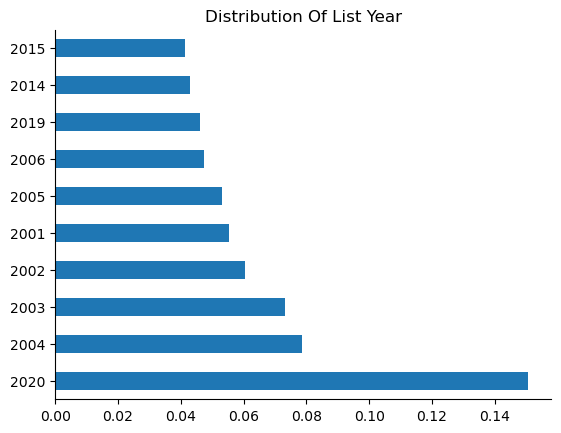

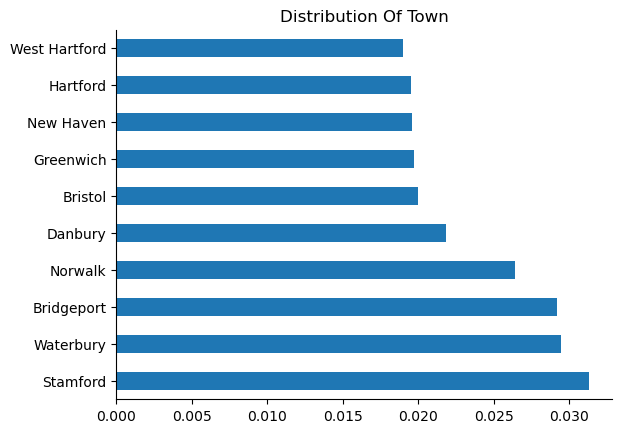

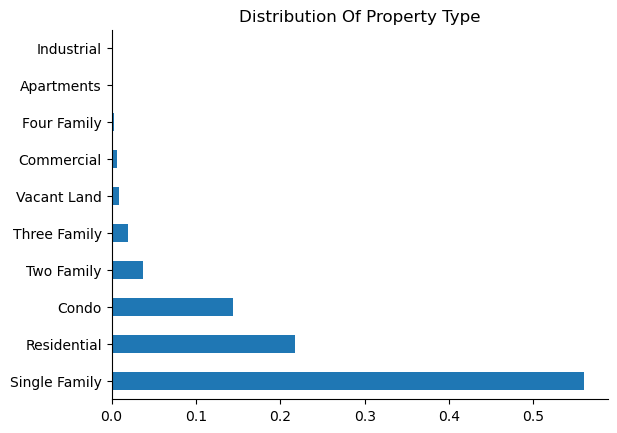

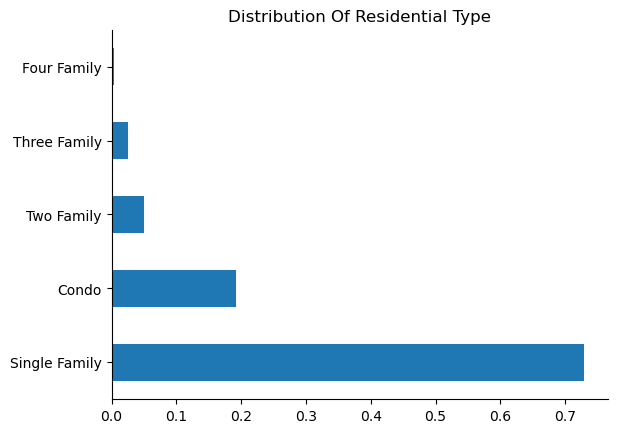

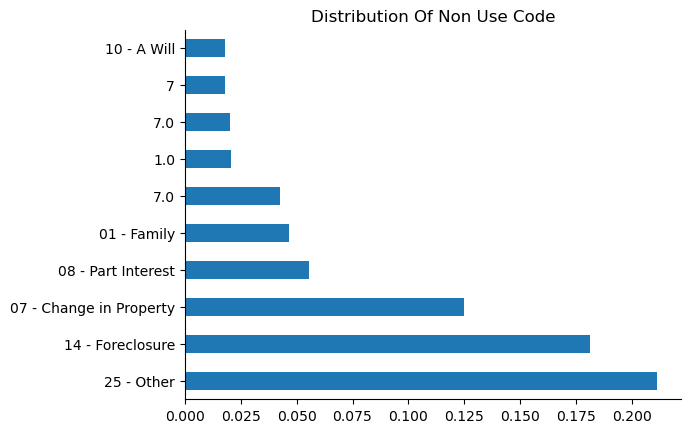

In [175]:
for column in small_values_columns:
    
    # limit to top 10 counts - too many locations to plot
    cleaned_real_estate[column].value_counts(normalize=True).head(10).plot(kind="barh")

    plt.title(f"Distribution of {column}".title())
    sns.despine()
    plt.show()

/var/folders/kv/4xjj0g696_lcyc7ms5pdd2t00000gn/T/ipykernel_16630/4054847819.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_df = cleaned_real_estate.corr()


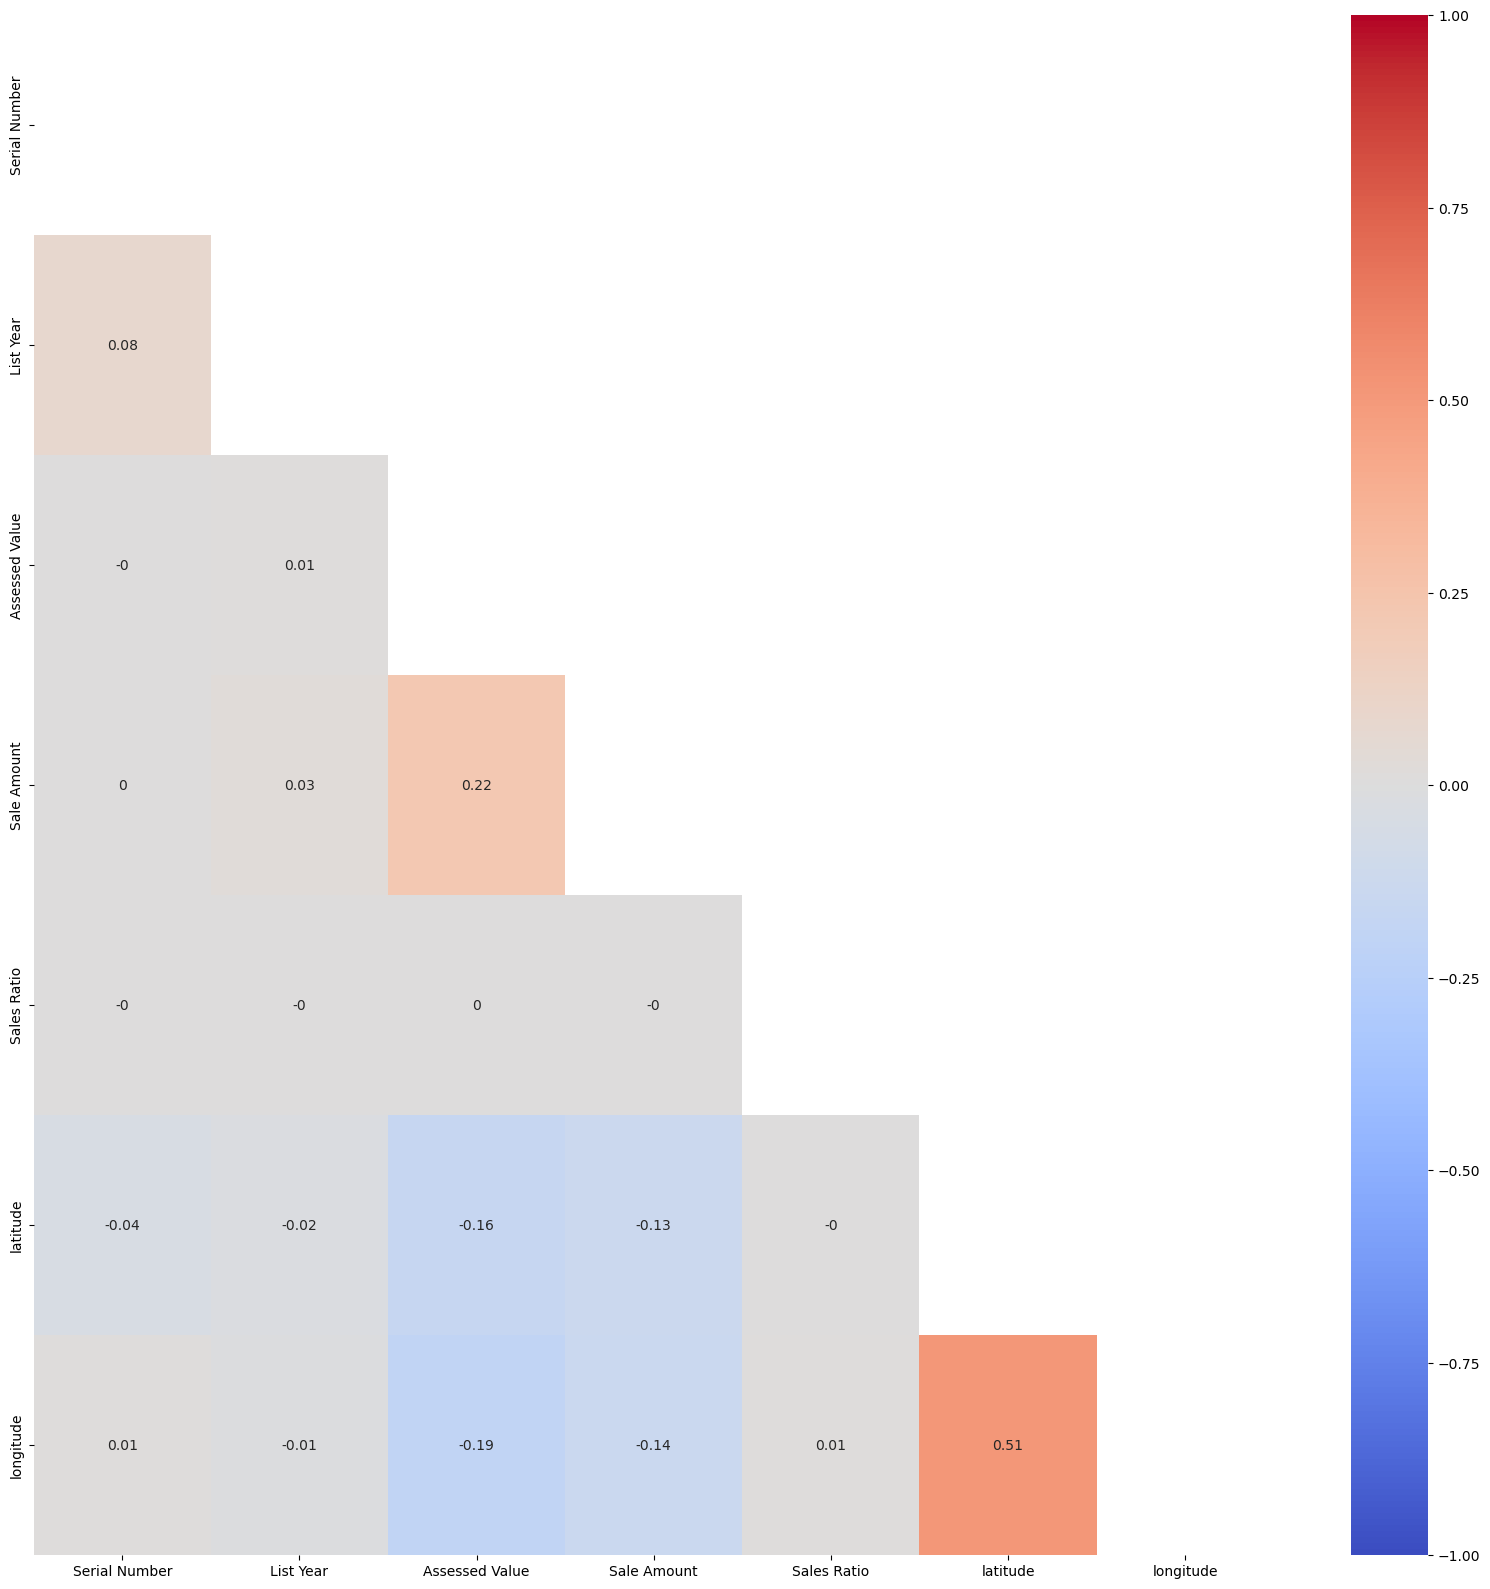

In [202]:
corr_df = cleaned_real_estate.corr()
mask = np.triu(corr_df)
plt.figure(figsize=(20,20))
sns.heatmap(corr_df.round(2), annot=True,mask=mask, vmin=-1, vmax=1, cmap='coolwarm')
plt.show()

Findings:
   - `Assessed Value` and `Sale Amount` is weakly correlated (r=0.11).
   
   - `latitude` and `longitude` moderately correlated (r=0.51)

In [162]:
real_estate.groupby(['Property Type', 'Residential Type'])['Property Type'].count() 

Property Type  Residential Type
Condo          Condo               105420
Four Family    Four Family           2150
Residential    Condo                12360
               Four Family            268
               Single Family        43404
               Three Family          1495
               Two Family            3201
Single Family  Single Family       401611
Three Family   Three Family         12586
Two Family     Two Family           26408
Name: Property Type, dtype: int64

In [164]:
real_estate.groupby(['Residential Type', 'Property Type'])['Residential Type'].count() 

Residential Type  Property Type
Condo             Condo            105420
                  Residential       12360
Four Family       Four Family        2150
                  Residential         268
Single Family     Residential       43404
                  Single Family    401611
Three Family      Residential        1495
                  Three Family      12586
Two Family        Residential        3201
                  Two Family        26408
Name: Residential Type, dtype: int64

[]

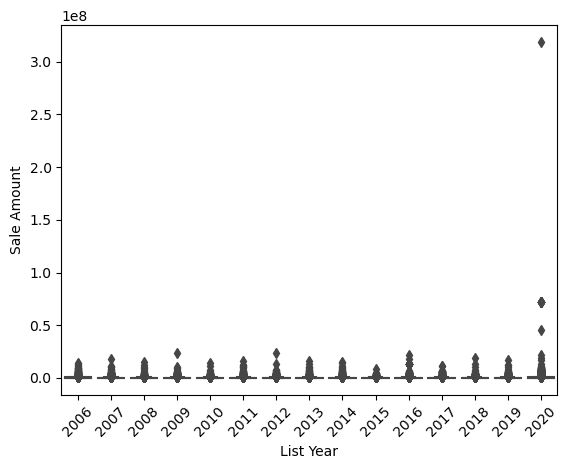

In [207]:
plt.figure()
sns.boxplot(x='List Year', y='Sale Amount', data=cleaned_real_estate)
plt.xticks(rotation=45)
plt.plot()

/var/folders/kv/4xjj0g696_lcyc7ms5pdd2t00000gn/T/ipykernel_16630/390298074.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  plt.barh(cleaned_real_estate.groupby('Property Type').mean()["Sale Amount"].index, cleaned_real_estate.groupby('Property Type').mean()["Sale Amount"])
/var/folders/kv/4xjj0g696_lcyc7ms5pdd2t00000gn/T/ipykernel_16630/390298074.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  plt.barh(cleaned_real_estate.groupby('Property Type').mean()["Sale Amount"].index, cleaned_real_estate.groupby('Property Type').mean()["Sale Amount"])


Text(0.5, 1.0, 'Mean Sale Amount by Property Type')

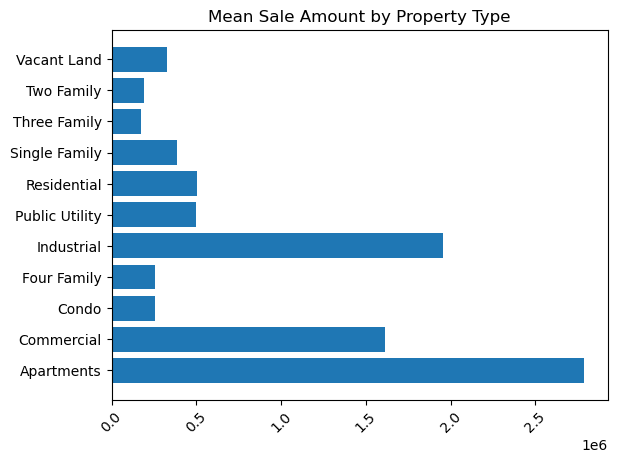

In [87]:
plt.barh(cleaned_real_estate.groupby('Property Type').mean()["Sale Amount"].index, cleaned_real_estate.groupby('Property Type').mean()["Sale Amount"])
plt.xticks(rotation=45)
plt.title('Mean Sale Amount by Property Type')


/var/folders/kv/4xjj0g696_lcyc7ms5pdd2t00000gn/T/ipykernel_16630/1661189277.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  plt.barh(cleaned_real_estate.groupby('List Year').mean()['Sale Amount'].index, cleaned_real_estate.groupby('List Year').mean()["Sale Amount"])
/var/folders/kv/4xjj0g696_lcyc7ms5pdd2t00000gn/T/ipykernel_16630/1661189277.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  plt.barh(cleaned_real_estate.groupby('List Year').mean()['Sale Amount'].index, cleaned_real_estate.groupby('List Year').mean()["Sale Amount"])


[]

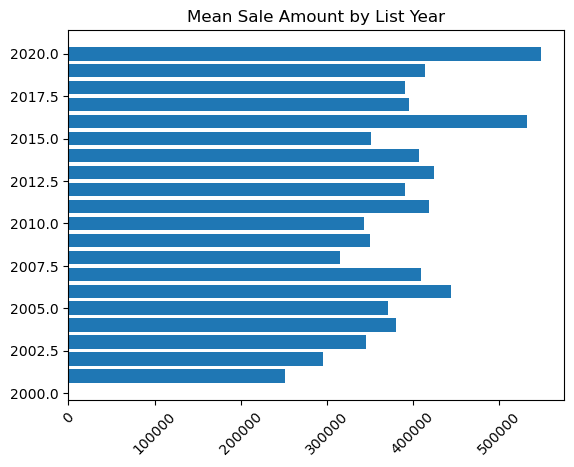

In [134]:
plt.figure()
plt.barh(cleaned_real_estate.groupby('List Year').mean()['Sale Amount'].index, cleaned_real_estate.groupby('List Year').mean()["Sale Amount"])
plt.xticks(rotation=45)
plt.title('Mean Sale Amount by List Year')
plt.plot()

/var/folders/kv/4xjj0g696_lcyc7ms5pdd2t00000gn/T/ipykernel_16630/442487251.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  plt.barh(cleaned_real_estate.groupby('List Year').median()['Sale Amount'].index, cleaned_real_estate.groupby('List Year').median()["Sale Amount"])
/var/folders/kv/4xjj0g696_lcyc7ms5pdd2t00000gn/T/ipykernel_16630/442487251.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  plt.barh(cleaned_real_estate.groupby('List Year').median()['Sale Amount'].index, cleaned_real_estate.groupby('List Year').median()["Sale Amount"])


[]

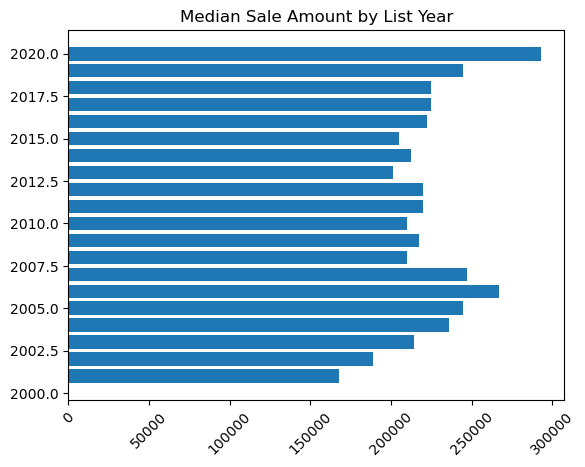

In [124]:
plt.figure()
plt.barh(cleaned_real_estate.groupby('List Year').median()['Sale Amount'].index, cleaned_real_estate.groupby('List Year').median()["Sale Amount"])
plt.xticks(rotation=45)
plt.title('Median Sale Amount by List Year')
plt.plot()

In [110]:

one_address_data = cleaned_real_estate[cleaned_real_estate['Address'] == "97 RICHARDS AVE"]
print(one_address_data.shape[0])
print(one_address_data["Sale Amount"].nunique())
print(one_address_data["Residential Type"].unique())
one_address_data.describe()
one_address_data.tail(20)


71
54
[nan 'Condo']


,Serial Number,List Year,Date Recorded,Town,Address,Assessed Value,Sale Amount,Sales Ratio,Property Type,Residential Type,Non Use Code,Assessor Remarks,OPM remarks,Full Address,latitude,longitude
96994,60719,2006,2007-03-07,Norwalk,97 RICHARDS AVE,181020.0,322000.0,0.562174,Condo,Condo,NaN,NaN,NaN,"97, Richards Ave, Norwalk, Connecticut, United...",-73.45225,41.096
102152,60602,2006,2007-02-05,Norwalk,97 RICHARDS AVE,181020.0,321500.0,0.563048,Condo,Condo,NaN,NaN,NaN,"97, Richards Ave, Norwalk, Connecticut, United...",-73.45225,41.096
102478,70178,2007,2007-11-09,Norwalk,97 RICHARDS AVE,182490.0,340000.0,0.536735,Condo,Condo,NaN,NaN,NaN,"97, Richards Ave, Norwalk, Connecticut, United...",-73.45225,41.096
103216,60859,2006,2007-04-25,Norwalk,97 RICHARDS AVE,184800.0,341000.0,0.541935,Condo,Condo,NaN,NaN,NaN,"97, Richards Ave, Norwalk, Connecticut, United...",-73.45225,41.096
103265,61123,2006,2007-05-11,Norwalk,97 RICHARDS AVE,182490.0,334000.0,0.546377,Condo,Condo,NaN,NaN,NaN,"97, Richards Ave, Norwalk, Connecticut, United...",-73.45225,41.096
105164,60257,2006,2006-11-28,Norwalk,97 RICHARDS AVE,181020.0,335000.0,0.540358,Condo,Condo,25 - Other,NaN,NaN,"97, Richards Ave, Norwalk, Connecticut, United...",-73.45225,41.096
105414,60025,2006,2006-10-05,Norwalk,97 RICHARDS AVE,182490.0,332500.0,0.548842,Condo,Condo,NaN,NaN,NaN,"97, Richards Ave, Norwalk, Connecticut, United...",-73.45225,41.096
152666,140359,2014,2015-01-15,Norwalk,97 RICHARDS AVE,163530.0,253000.0,0.646364,Condo,Condo,NaN,UNIT # C15,NaN,"97, Richards Ave, Norwalk, Connecticut, United...",-73.45225,41.096
167256,161213,2016,2017-07-20,Norwalk,97 RICHARDS AVE,160230.0,235000.0,0.681830,Condo,Condo,NaN,UNIT D16,NaN,"97, Richards Ave, Norwalk, Connecticut, United...",-73.45225,41.096
167994,161012,2016,2017-06-08,Norwalk,97 RICHARDS AVE,163530.0,250100.0,0.653858,Condo,Condo,NaN,UNIT G7,NaN,"97, Richards Ave, Norwalk, Connecticut, United...",-73.45225,41.096


In [111]:
one_address_data = real_estate[real_estate['Address'] == "8 SOUTH RD"]
print(one_address_data.shape[0])
print(one_address_data["Sale Amount"].nunique())
print(one_address_data["Residential Type"].unique())
one_address_data.describe()
one_address_data.tail(20)


420
84
[nan 'Single Family']


,Serial Number,List Year,Date Recorded,Town,Address,Assessed Value,Sale Amount,Sales Ratio,Property Type,Residential Type,Non Use Code,Assessor Remarks,OPM remarks,Location,Full Address
930685,18321,2018,2019-09-18,Stafford,8 SOUTH RD,1795500.0,5000.0,359.1000,NaN,NaN,08 - Part Interest,SALE OF CAMPSITE IN A COOP CAMPGROUND,NaN,NaN,"8, South Rd, Stafford, Connecticut, United States"
933570,18157,2018,2019-04-01,Stafford,8 SOUTH RD,1795500.0,4800.0,374.0625,NaN,NaN,08 - Part Interest,SALE OF CAMPSITE IN A COOP CAMPGROUND,NaN,NaN,"8, South Rd, Stafford, Connecticut, United States"
935257,18050,2018,2018-11-15,Stafford,8 SOUTH RD,1795500.0,5000.0,359.1000,NaN,NaN,08 - Part Interest,NaN,NaN,NaN,"8, South Rd, Stafford, Connecticut, United States"
937531,18239,2018,2019-06-24,Stafford,8 SOUTH RD,1795500.0,6500.0,276.2307,NaN,NaN,08 - Part Interest,SALE OF CAMPSITE IN A COOP CAMPGROUND,NaN,NaN,"8, South Rd, Stafford, Connecticut, United States"
938669,18051,2018,2018-11-15,Stafford,8 SOUTH RD,1795500.0,5000.0,359.1000,NaN,NaN,08 - Part Interest,SALE OF CAMPSITE IN A COOP CAMPGROUND,NaN,NaN,"8, South Rd, Stafford, Connecticut, United States"
938861,18055,2018,2018-11-20,Stafford,8 SOUTH RD,1795500.0,3000.0,598.5000,NaN,NaN,08 - Part Interest,NaN,NaN,NaN,"8, South Rd, Stafford, Connecticut, United States"
945416,18281,2018,2019-08-12,Stafford,8 SOUTH RD,1795500.0,5000.0,359.1000,NaN,NaN,08 - Part Interest,SALE OF CAMPSITE IN A COOP CAMPGROUND,NaN,NaN,"8, South Rd, Stafford, Connecticut, United States"
946654,18301,2018,2019-09-03,Stafford,8 SOUTH RD,1795500.0,4200.0,427.5000,NaN,NaN,08 - Part Interest,SALE OF CAMPSITE IN A COOP CAMPGROUND,NaN,NaN,"8, South Rd, Stafford, Connecticut, United States"
946729,18246,2018,2019-07-01,Stafford,8 SOUTH RD,1795500.0,5000.0,359.1000,NaN,NaN,08 - Part Interest,SALE OF CAMPSITE IN A COOP CAMPGROUND,NaN,NaN,"8, South Rd, Stafford, Connecticut, United States"
951378,18047,2018,2018-11-15,Stafford,8 SOUTH RD,1795500.0,10000.0,179.5500,NaN,NaN,08 - Part Interest,NaN,NaN,NaN,"8, South Rd, Stafford, Connecticut, United States"


In [95]:
one_address_data = real_estate[real_estate['Address'] == "8 SOUTH RD"]

# Count the number of rows for this address
print("Number of rows:", one_address_data.shape[0])

# Count the number of unique sale prices and display the minimum sale price
unique_sale_prices = one_address_data["Sale Amount"].nunique()
min_sale_price = min(one_address_data["Sale Amount"].unique())
max_sale_price = max(one_address_data["Sale Amount"].unique())

print(f"There are {unique_sale_prices} unique sale prices from ${min_sale_price:.2f} to ${max_sale_price:.2f}")


Number of rows: 420
There are 84 unique sale prices from $0.00 to $6500000.00


(array([83.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([      0.,  650000., 1300000., 1950000., 2600000., 3250000.,
        3900000., 4550000., 5200000., 5850000., 6500000.]),
 <BarContainer object of 10 artists>)

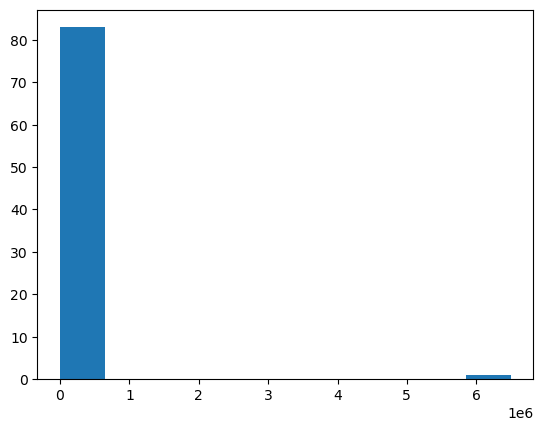

In [112]:
unique_sale_amounts = one_address_data["Sale Amount"].unique()
unique_sale_amounts_sorted = sorted(unique_sale_amounts)
plt.hist(unique_sale_amounts_sorted)



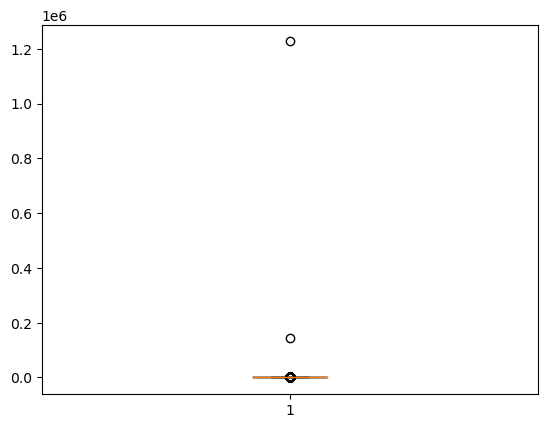

In [203]:
unique_sale_amounts = cleaned_real_estate["Sales Ratio"]
plt.figure()
plt.boxplot(unique_sale_amounts)
plt.show()


In [204]:
print(real_estate[real_estate['Sales Ratio'] == real_estate['Sales Ratio'].max()])

        Serial Number  List Year Date Recorded       Town      Address  \
421304          60043       2006    2007-03-19  Salisbury  209 MAIN ST   

        Assessed Value  Sale Amount  Sales Ratio  Property Type  \
421304       1226420.0          1.0    1226420.0  Single Family   

       Residential Type           Non Use Code Assessor Remarks OPM remarks  \
421304    Single Family  29 - No Consideration              NaN         NaN   

                          Location  \
421304  POINT (-73.43333 41.97247)   

                                             Full Address  
421304  209, Main St, Salisbury, Connecticut, United S...  


In [131]:
weird_sales_ratio = real_estate[real_estate['Sales Ratio'] > 300]
weird_sales_ratio["Assessor Remarks"].isna().sum() / weird_sales_ratio["Assessor Remarks"].notnull().sum()



0.6320346320346321

1256 rows with missing the full addess despite the address being in the "Address" column was investigated
data_with_coordinates.isna().sum()

,Serial Number,List Year,Date Recorded,Town,Address,Assessed Value,Sale Amount,Sales Ratio,Property Type,Residential Type,Non Use Code,Assessor Remarks,OPM remarks,Full Address,latitude,longitude
0,200086,2020,2021-08-10,Bethlehem,39 WOODLAND RD,168900.0,352000.0,0.479800,Residential,Single Family,NaN,NaN,NaN,"39, Woodland Rd, Bethlehem, Connecticut, Unite...",-73.18197,41.64672
3,200639,2020,2021-07-28,Groton,4 TYLER AVE,259770.0,650000.0,0.399646,Residential,Single Family,NaN,NaN,NaN,"4, Tyler Ave, Groton, Connecticut, United States",-72.07229,41.32148
4,200020,2020,2020-10-06,Groton,98 EAST SHORE AVE,654570.0,990000.0,0.661182,Residential,Single Family,07 - Change in Property,TEAR DOWN,NaN,"98, East Shore Ave, Groton, Connecticut, Unite...",-72.00446,41.31252
5,200038,2020,2020-10-09,Meriden,41 SUNNY LANE,209440.0,307000.0,0.682200,Residential,Single Family,NaN,NaN,NaN,"41, Sunny Lane, Meriden, Connecticut, United S...",-72.79013,41.51639
6,200374,2020,2021-05-18,Vernon,27 TRACY DRIVE,129190.0,226800.0,0.569600,Residential,Single Family,NaN,NaN,NaN,"27, Tracy Drive, Vernon, Connecticut, United S...",-72.47857,41.84938
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197691,190389,2019,2020-03-24,Norwich,17 VINE ST,86600.0,182000.0,0.475800,Three Family,Three Family,NaN,NaN,NaN,"17, Vine St, Norwich, Connecticut, United States",-72.07006,41.53315
197692,190478,2019,2020-02-14,Norwalk,38 HYATT AVE,283180.0,440000.0,0.643600,Single Family,Single Family,14 - Foreclosure,FORECLOSURE BY SALE: 1-7-9-0,NaN,"38, Hyatt Ave, Norwalk, Connecticut, United St...",-73.42700,41.11112
197693,190159,2019,2020-07-23,Weston,62 RIDGE ROAD,516990.0,790000.0,0.654400,Single Family,Single Family,NaN,NaN,NaN,"62, Ridge Road, Weston, Connecticut, United St...",-73.38341,41.19079
197694,190105,2019,2020-02-25,Plymouth,18 OVERLOOK RD,104130.0,80000.0,1.301625,Single Family,Single Family,14 - Foreclosure,NaN,BANK SALE PER MLS,"18, Overlook Rd, Plymouth, Connecticut, United...",-72.98492,41.64753
